Alexander S. Lundervold, October 22nd, 2018

# Introduction

Random forests are **ensembles** of decision trees. As we've seen, a single decsion tree is typically very sensitive to small changes in the training data and they tend to overfit. However, by constructing multiple decision trees in a particular way, and then combine them to make predictions, these problems are mitigated. As well as being less sensitive and less prone to overfitting, the resulting models, called **random forests**, have much higher performance. 

One way to motivate ensembling techniques is through the concept of *<a href="https://en.wikipedia.org/wiki/Wisdom_of_the_crowd">wisdom of the crowd</a>*. In many situations, a crowd of non-expert that combine their predictions outperform individual experts. 

The idea is not new, of course. Here's Aristotle pointing this out back in 350 B.C.E:
> *For the many, of whom each individual is but an ordinary person, when they meet together may very likely be better than the few good, if regarded not individually but collectively, just as a feast to which many contribute is better than a dinner provided out of a single purse* <br>&ndash; Aristotle, <a href="http://classics.mit.edu/Aristotle/politics.3.three.html">Politics Book III</a>

See also Geron's notebook: https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb

# Setup

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
from pathlib import Path # Very convenient when working with paths in Python (https://docs.python.org/3.6/library/pathlib.html)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Ensembling

*Ensembling* is a general technique for combining machine learning models to make even more powerful models. 

There are several variants of this, as we'll see. **Voting**, **bagging**, **boosting**, **stacking**. We'll meet these concepts as we go along. You should also read through chapter 7 of the textbook as we won't cover all the details.

Two very powerful and widely used models made using ensembling are **random forests** and **gradient boosted decision trees**. We'll look at random forests here and gradient boosting in the next notebook. 

# Random forests

As we've seen, single decision trees tend to be very sensitive to the exact training data it's fed, and also tend to overfit. 

By training multiple decision trees on different parts of the training data, each one may overfit and be very sensitive, but by *averaging* their predicions the sensitivity is reduced and the overfitting combatted. 

Let's say we want to build 500 trees on a training set containing `n_samples` point. Each tree is built in the following way:

1. Choose one data point at random for the training data, **with replacement**. Do this `n_samples` times, that is, until you have `n_samples` points. This is called **bootstrap sampling**. Each tree is trained on different data sets. 
2. Train a decision tree on this data set, but at each node of the tree **select a random set of features to consider when splitting**, up to `max_features` of them. Each tree is trained on different features. 

This is a random forest.

Predictions from a random forest is done differently for regression and classificataion: 

- **Regression:** Let each tree make a prediction, then average them.
- **Classification:** Let each tree make a prediction, and use a **soft voting strategy** to combine them. Each tree provides a probability for its prediction. Average these probabilites and predict the class that has the highest average probability. 

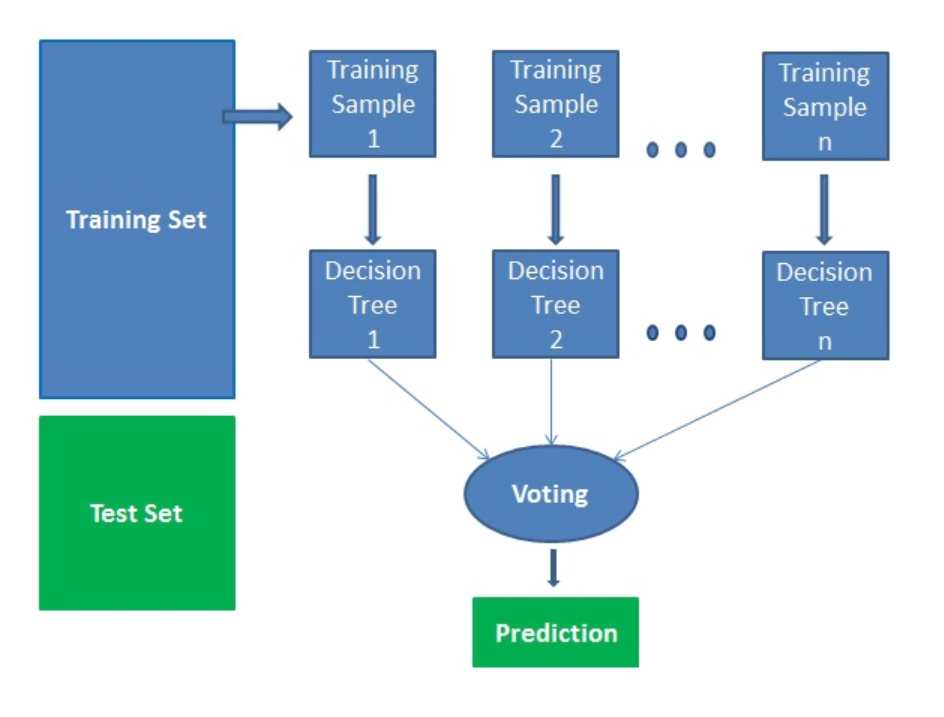

In [4]:
import IPython
IPython.display.Image("assets/rf_datacamp.png", width='70%')

<center><small>Picture from <a href="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg">here</a></center>

> **Your turn!** When you find the time it's highly recommended that you work through exercise 8 in Chapter 6 of the textbook. You'll find some hints at the end of this notebook (don't look at them until you've tried to solve the exercise yourself). 

Let's try it out on a couple of (slightly complicated) data sets. 

> **Note:** We will not do a whole lot of data preparation or feature engineering. We'll also not investigate the data sets very thoroughly. Feel free to add more details to the stories told below (following the steps in Assignemnt 1, for example). 

## Downloading data

Before getting to the random forest, let's have a quick look at ways of downloading data. 

We'll fetch our data from the OpenML repository at https://openml.org and from Kaggle, using the Kaggle API https://github.com/Kaggle/kaggle-api.

*If the below command fails you should update your DAT158 environment (go into the DAT158ML repository and run `conda env update`). `fetch_openml`requires scikit-learn >= 0.20*, and you're likely running 0.19.

In [5]:
from sklearn.datasets import fetch_openml

> You should always try to download the data directly from your Jupyter Notebook! It helps a lot with reproducibility, and makes it easier to understand what you're work (for yourself and others)

# Classification

## Download the data and have a quick look

In [6]:
dating = fetch_openml(name='SpeedDating')

> **Note:** This data set is also available from Kaggle https://www.kaggle.com/annavictoria/speed-dating-experiment. And in fact it's simpler to download it from there (using the Kaggle API). However, we want to be ready for a variety of possible data formats and sources that are out there. But you should try to repeat what we do below by downloading the data from Kaggle using the Kaggle API.

This returns a `Bunch`:

In [7]:
type(dating)

sklearn.utils.Bunch

containing the entire data set including descriptions, accessible by keys:

In [8]:
dating.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

Here's the description:

In [9]:
print(dating['DESCR'])

**Author**: Ray Fisman and Sheena Iyengar  
**Source**: [Columbia Business School](http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/) - 2004  
**Please cite**: None  

This data was gathered from participants in experimental speed dating events from 2002-2004. During the events, the attendees would have a four-minute "first date" with every other participant of the opposite sex. At the end of their four minutes, participants were asked if they would like to see their date again. They were also asked to rate their date on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests. The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information. 

### Attribute Information
```
 * gender: Gender of self  
 * age: Age of self  
 * age_o: 

The actual data is stored under the key `data`. It is a Numpy array with 8378 instances each with 120 features:

In [10]:
dating['data'].shape

(8378, 120)

We prefer working with Pandas DataFrames, so let's create one:

In [11]:
X = pd.DataFrame(data=dating.data, columns=dating.feature_names)
y = dating.target

In [12]:
len(X), len(y)

(8378, 8378)

In [13]:
X.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
0,0.0,1.0,0.0,21.0,27.0,6.0,0.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
1,0.0,1.0,0.0,21.0,22.0,1.0,1.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,7.0,5.0,0.0,0.0,1.0
2,1.0,1.0,0.0,21.0,22.0,1.0,1.0,0.0,1.0,1.0,...,2.0,4.0,0.0,0.0,0.0,7.0,NaN,0.0,1.0,1.0
3,0.0,1.0,0.0,21.0,23.0,2.0,2.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
4,0.0,1.0,0.0,21.0,24.0,3.0,2.0,0.0,2.0,0.0,...,2.0,4.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0


In [14]:
X.head(15).T.head(20) # The first 15 instances and the first 20 features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
has_null,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wave,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
gender,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.00,21.0,21.0,24.0,24.0,24.0,24.0,24.0
age_o,27.0,22.0,22.0,23.0,24.0,25.0,30.0,27.00,28.0,24.0,27.0,22.0,22.0,23.0,24.0
d_age,6.0,1.0,1.0,2.0,3.0,4.0,9.0,6.00,7.0,3.0,3.0,2.0,2.0,1.0,0.0
d_d_age,0.0,1.0,1.0,2.0,2.0,0.0,3.0,0.00,3.0,2.0,2.0,2.0,2.0,1.0,1.0
race,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,1.0,1.0,1.0,1.0
race_o,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,2.0
samerace,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,1.0,0.0,1.0,0.0


## Data exploration and preparation

### Dealing with missing values

There are many missing values in this data set, and we have to deal with them:

Total missing:

In [15]:
X.isnull().sum().sum()

18372

Missing by feature:

In [16]:
X.isnull().sum()

has_null                              0
wave                                  0
gender                                0
age                                  95
age_o                               104
d_age                                 0
d_d_age                               0
race                                 63
race_o                               73
samerace                              0
importance_same_race                 79
importance_same_religion             79
d_importance_same_race                0
d_importance_same_religion            0
field                                63
pref_o_attractive                    89
pref_o_sincere                       89
pref_o_intelligence                  89
pref_o_funny                         98
pref_o_ambitious                    107
pref_o_shared_interests             129
d_pref_o_attractive                   0
d_pref_o_sincere                      0
d_pref_o_intelligence                 0
d_pref_o_funny                        0


Let's not think much about it and just drop the column `expected_num_interested_in_me` which has a *lot* of missing values, and put in the most common value elsewhere:

In [17]:
X.drop('expected_num_interested_in_me', axis=1, inplace=True)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 119 entries, has_null to met
dtypes: float64(119)
memory usage: 7.6 MB


Impute the rest of the values (as you did in Assignment 1):

In [19]:
from sklearn.impute import SimpleImputer

In [20]:
imputer = SimpleImputer(strategy='most_frequent')

In [21]:
X_transformed = imputer.fit_transform(X)

In [22]:
X = pd.DataFrame(X_transformed, columns=X.columns)

In [23]:
X.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_happy_with_sd_people,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
0,0.0,1.0,0.0,21.0,27.0,6.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
1,0.0,1.0,0.0,21.0,22.0,1.0,1.0,0.0,0.0,0.0,...,3.0,4.0,0.0,0.0,0.0,7.0,5.0,0.0,0.0,1.0
2,1.0,1.0,0.0,21.0,22.0,1.0,1.0,0.0,1.0,1.0,...,3.0,4.0,0.0,0.0,0.0,7.0,5.0,0.0,1.0,1.0
3,0.0,1.0,0.0,21.0,23.0,2.0,2.0,0.0,0.0,0.0,...,3.0,4.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
4,0.0,1.0,0.0,21.0,24.0,3.0,2.0,0.0,2.0,0.0,...,3.0,4.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0


No more missing values:

In [24]:
X.isnull().sum().sum()

0

We notice that all the values seem to be integers, not floats. Let's guess that that's the case, and convert all the non-missing values to integers:

In [25]:
X = X.astype('int32')

In [26]:
X.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_happy_with_sd_people,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
0,0,1,0,21,27,6,0,0,0,0,...,3,4,0,0,0,7,6,0,0,0
1,0,1,0,21,22,1,1,0,0,0,...,3,4,0,0,0,7,5,0,0,1
2,1,1,0,21,22,1,1,0,1,1,...,3,4,0,0,0,7,5,0,1,1
3,0,1,0,21,23,2,2,0,0,0,...,3,4,0,0,0,7,6,0,0,0
4,0,1,0,21,24,3,2,0,2,0,...,3,4,0,0,0,6,6,0,0,0


In [27]:
X.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 119 columns):
has_null                           int32
wave                               int32
gender                             int32
age                                int32
age_o                              int32
d_age                              int32
d_d_age                            int32
race                               int32
race_o                             int32
samerace                           int32
importance_same_race               int32
importance_same_religion           int32
d_importance_same_race             int32
d_importance_same_religion         int32
field                              int32
pref_o_attractive                  int32
pref_o_sincere                     int32
pref_o_intelligence                int32
pref_o_funny                       int32
pref_o_ambitious                   int32
pref_o_shared_interests            int32
d_pref_o_attractive            

> We notice that many variables that are really categorical, even binary like `gender`. It's not necessary to store them as int32. It would be convenient to convert all categorical variables (there are 64 of them), and keep the numeric attributes (there are 59) as integers. 

### Exploring the data

Let's explore the data a bit (but just a bit! Feel free to explore further on your own, perhaps by following the steps you took in Assignment 1).

We need to split off a test set before we start digging into the data:

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Let's look at the age and gender distribution:

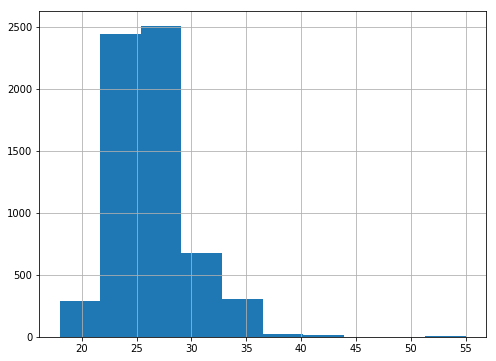

In [30]:
X_train['age'].hist(figsize=(8,6))
plt.show()

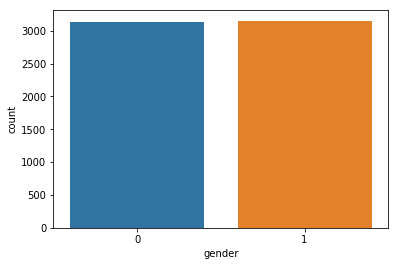

In [31]:
sns.countplot(X_train['gender'])
plt.show()

We notice that the speed dating event was quite balanced among the genders (which, typically, is convenient for such an event). 

How successful were the participants? Let's count the number of people that found a match. This is stored in y:

In [32]:
y[:5]

array(['0', '0', '1', '1', '1'], dtype=object)

...as strings, it seems. It's more convenient to store it as integers: 

In [33]:
y = [int(i) for i in y]

Percentage of matches:

In [34]:
np.sum(y)/len(y) * 100

16.47171162568632

Only 16% of participants found a match after the speed dating experiment..

> Feel free to explore the data set further, perhaps by following your approach in Assignment 1 / Chapter 2. What can you say about correlations? Are there any features you should add? 

Let's move on to our random forest:

## Random forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rf_clf = RandomForestClassifier(bootstrap=False, n_estimators=100, max_depth=30, random_state=42)

In [37]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [38]:
rf_clf.score(X_test, y_test)

0.863961813842482

We can predict who will get a second date with more than 86% accuracy!

> And now for what everyone's waiting for: what are the most important features for getting a second date?

In [39]:
importances = rf_clf.feature_importances_

In [40]:
indices = np.argsort(importances)[::-1]

Here are the top 10:

In [41]:
for f in range(10): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

attractive_o: 0.03
attractive_partner: 0.03
like: 0.03
funny_o: 0.03
shared_interests_o: 0.03
funny_partner: 0.02
guess_prob_liked: 0.02
shared_interests_partner: 0.02
d_attractive_o: 0.02
pref_o_attractive: 0.01


How does this differ between men and women? To find out, we can train one model on men and another on women.

In [42]:
X_train_men, y_train_men = X_train.loc[X_train['gender'] == 1], y_train[X_train['gender'] == 1]

X_train_women, y_train_women = X_train.loc[X_train['gender'] == 0], y_train[X_train['gender'] == 0]

In [43]:
rf_clf_men = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_men.fit(X_train_men, y_train_men)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [44]:
rf_clf_women = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_women.fit(X_train_women, y_train_women)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [45]:
def print_feature_importances(clf, num):
    """
    Prints the num most important features of the trained classifier clf
    """
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(num): 
        print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],3)}')

In [46]:
print_feature_importances(rf_clf_men, 10)

attractive_o: 0.037
shared_interests_o: 0.035
attractive_partner: 0.033
funny_o: 0.03
like: 0.027
guess_prob_liked: 0.027
shared_interests_partner: 0.019
funny_partner: 0.019
pref_o_shared_interests: 0.016
pref_o_attractive: 0.015


In [47]:
print_feature_importances(rf_clf_women, 10)

like: 0.036
funny_partner: 0.034
attractive_partner: 0.033
attractive_o: 0.03
shared_interests_partner: 0.029
shared_interests_o: 0.025
funny_o: 0.025
guess_prob_liked: 0.023
pref_o_attractive: 0.016
pref_o_shared_interests: 0.015


Notice that we overfit the training data:

In [48]:
rf_clf.score(X_train, y_train)

1.0

Looking at the parameters of the random forest above, and thinking back to decision trees, we can guess how we can regularize the model to reduce the overfitting. For example, we can reduce the minimum number of samples each leaf must contain, and/or the maximum number of leaf nodes:

In [49]:
rf_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, max_leaf_nodes=20, random_state=42)

In [50]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [51]:
rf_clf.score(X_test, y_test)

0.8482100238663485

In [52]:
rf_clf.score(X_train, y_train)

0.8540506127646029

## Wait a minute!

We are pretty happy with ourselves: we're able to predict matches with an accuracy of 85%, and we've found some fun results on gender differences in dating. 

<br><br>
<center><b><span style="font-size:300%">BUT!</span></b></center>

Only 16% of the participants are marked as matches. Therefore, if we predict everyone to be `match=0` we'll score about 84%... Making 85% not very impressive.. 

If only there were ways to evaluate classifiers more carefully than accuracy... :-) Luckily, we've studied classification very thoroughly in Part 2, and are equipped with many tools. 

In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
y_pred = rf_clf.predict(X_test)

In [55]:
cm = confusion_matrix(y_test, y_pred)

In [56]:
import itertools

*Below code taken from Part 2*:

In [57]:
def plot_confusion_matrix(cm, classes, ax=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, labels=True):
    """
    This function prints and plots the confusion matrix.
    From 
    """
    
    if not ax: fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.setp(ax, xticks=tick_marks, xticklabels=classes, 
             yticks=tick_marks, yticklabels=classes,
             title=title, xlabel="Predicted label", 
             ylabel="True label")
    #ax.set_xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if labels:
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return ax

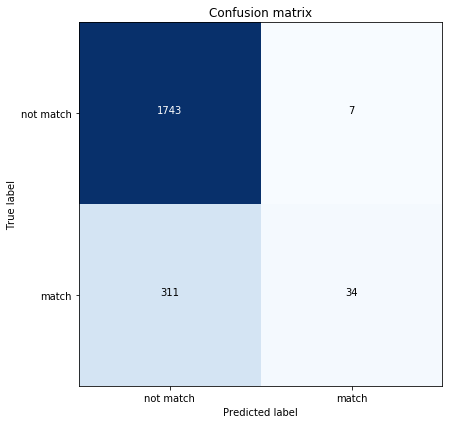

In [58]:
_ = plot_confusion_matrix(cm, ['not match', 'match'])

We see that our model is **almost rubbish**! Invalidating all the fun observations we did above. Beware of such mistakes!

# Regression

Let's study happiness! Can we predict how happy the population of a country is? 

We'll use data from the United Nations World Happiness Report: http://worldhappiness.report, conveniently organized on Kaggle: https://www.kaggle.com/unsdsn/world-happiness

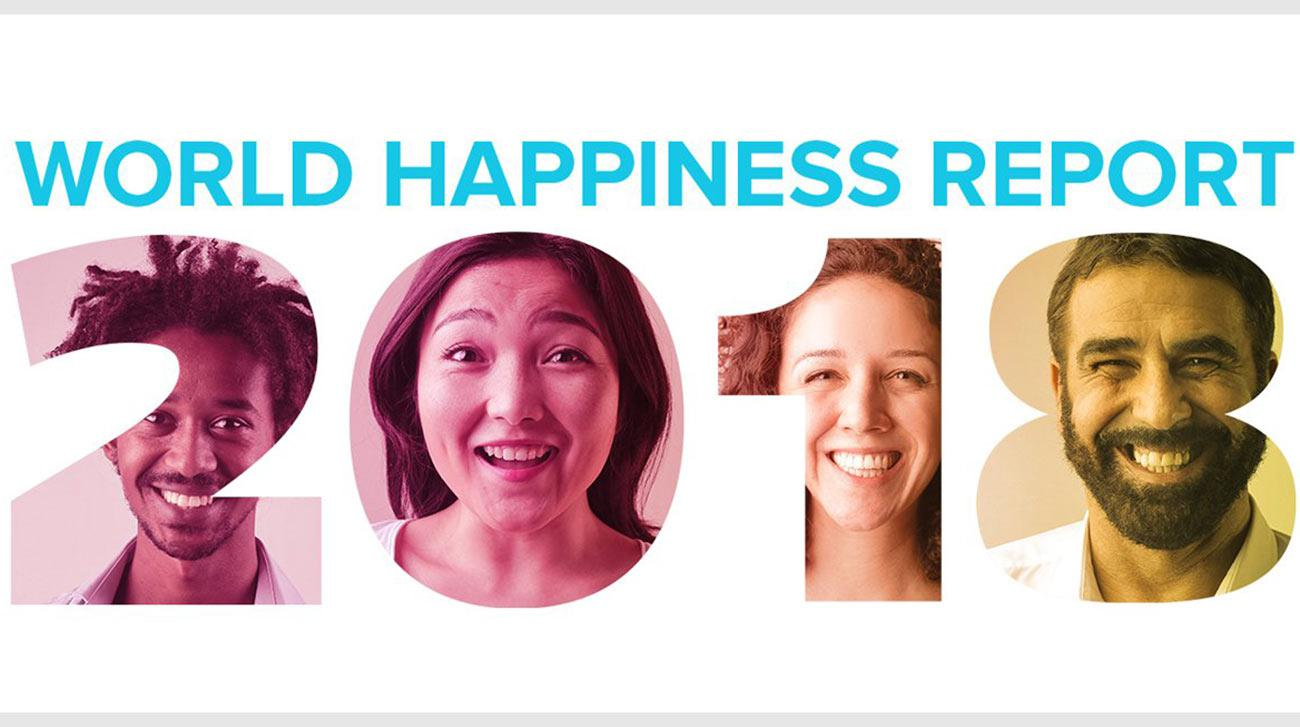

In [59]:
IPython.display.Image("assets/happines-web.jpg", width='70%')

## Get the data

First we need to decide where to store the data. Any time you work with paths in Python you should consider <a href="https://docs.python.org/3.6/library/pathlib.html">pathlib</a>. It's super convenient. 

In [60]:
from pathlib import Path

In [61]:
NB_DIR = %pwd # Sets NB_DIR to the current directory
NB_DIR = Path(NB_DIR)

In [62]:
DATA = NB_DIR/'data'

In [63]:
DATA.mkdir(exist_ok=True)

We'll run our Kaggle API command from within Python using the <a href="https://docs.python.org/3.6/library/subprocess.html">subprocess</a> module. 

In [64]:
import subprocess

In [65]:
command = f'kaggle datasets download -d unsdsn/world-happiness -p {DATA}'

In [66]:
subprocess.call(command, shell=True)

0

*If the above command fails, you probably haven't set up your Kaggle API correctly. Have you remembered to generate an API token?*

We see that we've downloaded a zip file:

In [67]:
%ls $DATA

 Volume in drive C is Local Disk
 Volume Serial Number is 82A6-EE0C

 Directory of C:\Users\alexa\Dropbox\Jobb\HIB\Kurs\DAT158\DAT158ML\Part4-tree_based_models\data

10/22/2018  11:23 AM    <DIR>          .
10/22/2018  11:23 AM    <DIR>          ..
10/22/2018  11:23 AM            29,425 world-happiness.zip
               1 File(s)         29,425 bytes
               2 Dir(s)  740,294,270,976 bytes free


Let's unzip it:

In [68]:
import zipfile

In [69]:
with zipfile.ZipFile(DATA/'world-happiness.zip',"r") as zip_ref:
    zip_ref.extractall(DATA)

In [70]:
%ls $DATA

 Volume in drive C is Local Disk
 Volume Serial Number is 82A6-EE0C

 Directory of C:\Users\alexa\Dropbox\Jobb\HIB\Kurs\DAT158\DAT158ML\Part4-tree_based_models\data

10/22/2018  11:23 AM    <DIR>          .
10/22/2018  11:23 AM    <DIR>          ..
10/22/2018  11:23 AM            16,557 2015.csv
10/22/2018  11:23 AM            17,132 2016.csv
10/22/2018  11:23 AM            29,536 2017.csv
10/22/2018  11:23 AM            29,425 world-happiness.zip
               4 File(s)         92,650 bytes
               2 Dir(s)  740,294,262,784 bytes free


There are three new .csv files: 2015.csv, 2016.csv, 2017.csv. Let's use the one from 2016 for now:

In [71]:
happiness = pd.read_csv(DATA/'2016.csv')

## Inspect the data

In [72]:
happiness.head()

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


We'll try to predict the Happiness Score from the other features, dropping the Happiness Rank and also the name of the country (it's likely not very relevant for predicting happiness, at least when we know the country's region).

The features *Lower Confidence Interval* and *Upper Confidence Interval* are also not useful for our predictions.

In [73]:
happiness = happiness.drop(['Lower Confidence Interval', 'Upper Confidence Interval'], axis=1)

In [74]:
X = happiness.drop([
    'Happiness Rank',
    'Country',
    'Happiness Score'],
    axis=1
)
y = happiness['Happiness Score']

In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 8 columns):
Region                           157 non-null object
Economy (GDP per Capita)         157 non-null float64
Family                           157 non-null float64
Health (Life Expectancy)         157 non-null float64
Freedom                          157 non-null float64
Trust (Government Corruption)    157 non-null float64
Generosity                       157 non-null float64
Dystopia Residual                157 non-null float64
dtypes: float64(7), object(1)
memory usage: 9.9+ KB


In [76]:
X.describe()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.953880,0.793621,0.557619,0.370994,0.137624,0.242635,2.325807
std,0.412595,0.266706,0.229349,0.145507,0.111038,0.133756,0.542220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817890
25%,0.670240,0.641840,0.382910,0.257480,0.061260,0.154570,2.031710
50%,1.027800,0.841420,0.596590,0.397470,0.105470,0.222450,2.290740
75%,1.279640,1.021520,0.729930,0.484530,0.175540,0.311850,2.664650
max,1.824270,1.183260,0.952770,0.608480,0.505210,0.819710,3.837720


We see that there are no missing values. All the values except Region are floats. 

As we remember from Assignment 1, it's a good idea to get a feel for the data by visualizing the features using histograms, correlations and boxplots:

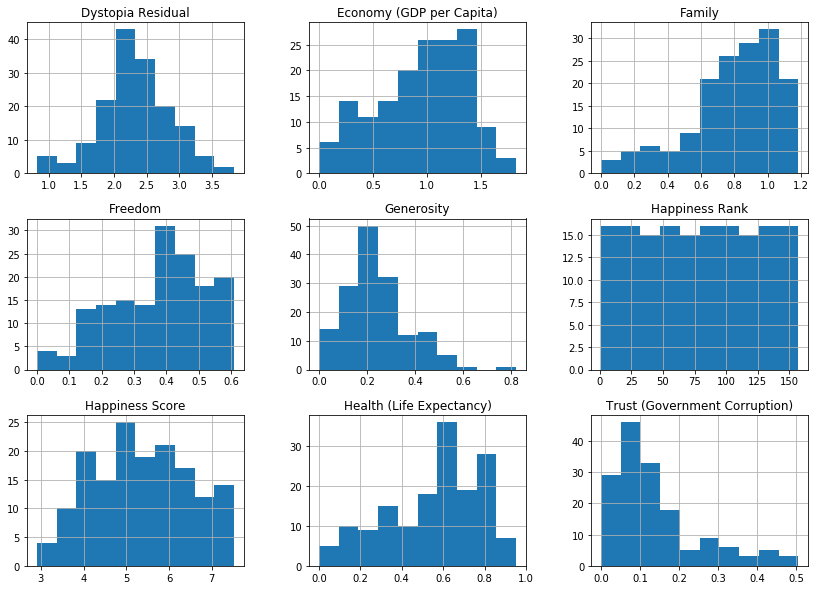

In [77]:
happiness.hist(figsize=(14,10))
plt.show()

`Region` is a categorical features. 

In [78]:
happiness['Region'].value_counts()

Sub-Saharan Africa                 38
Central and Eastern Europe         29
Latin America and Caribbean        24
Western Europe                     21
Middle East and Northern Africa    19
Southeastern Asia                   9
Southern Asia                       7
Eastern Asia                        6
North America                       2
Australia and New Zealand           2
Name: Region, dtype: int64

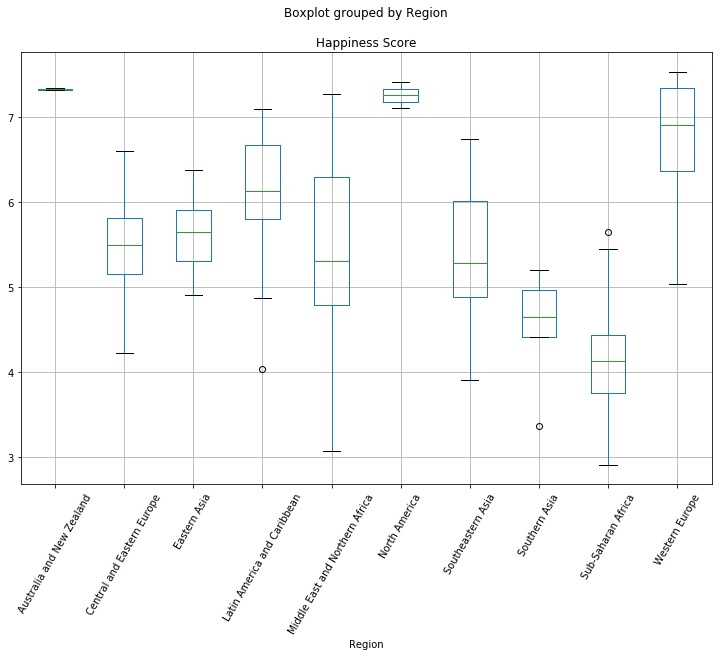

In [79]:
happiness.boxplot('Happiness Score', 'Region', rot=60, figsize=(12,8))
plt.show()

Using Seaborn we can get a nicer looking plot:

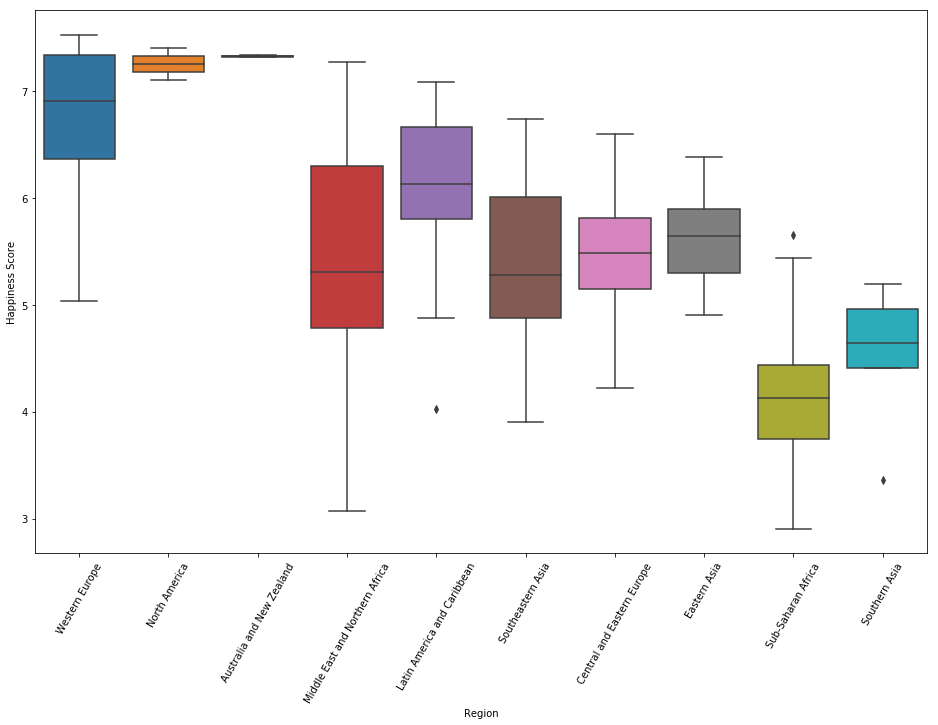

In [80]:
plt.figure(figsize=(16,10))
ax = sns.boxplot(x='Region', y='Happiness Score', data=happiness)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
plt.show()

We already notive many interesting things about the happiness distribution! For example, the region with the largest spread in happiness is *Middle East and Northern Africa*. *North America* has little spread, but it only consists of two countries.. 

Looking at the correlations among different features (as in Assignment 1) is also very useful:

In [81]:
from pandas.plotting import scatter_matrix

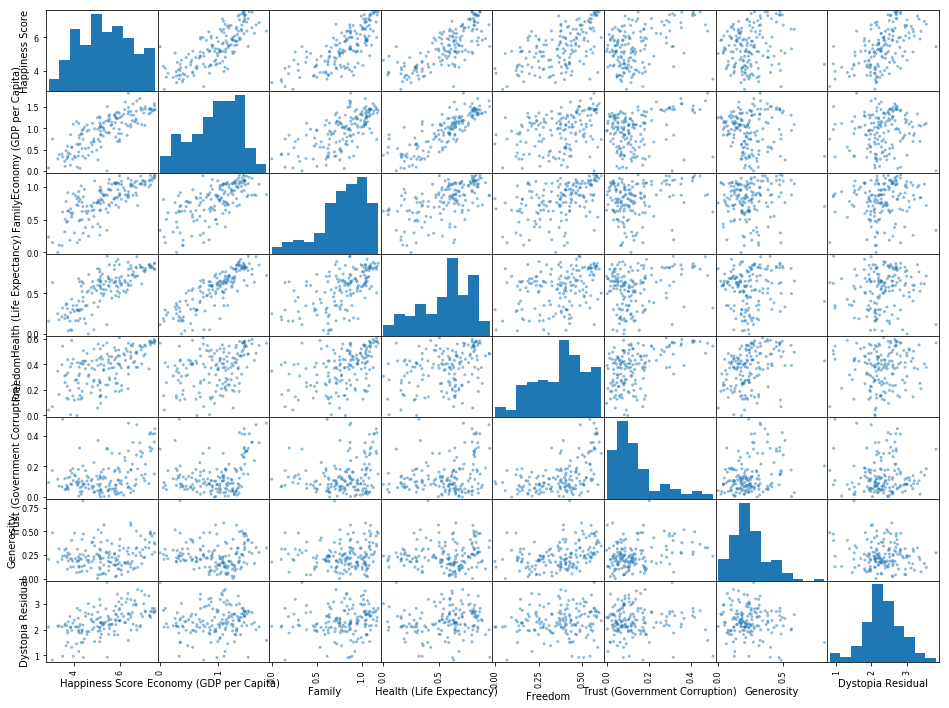

In [82]:
scatter_matrix(happiness.drop(['Happiness Rank', 'Country'], axis=1), figsize=(16,12))
plt.show()

We notice from the above plots that there are some correlations between the Happiness Score (top row) and other features. 

We can also look at these correlations directly:

In [83]:
corr_matrix = happiness.drop(['Happiness Rank', 'Country'], axis=1).corr()

In [84]:
corr_matrix

,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Happiness Score,1.000000,0.790322,0.739252,0.765384,0.566827,0.402032,0.156848,0.543738
Economy (GDP per Capita),0.790322,1.000000,0.669540,0.837067,0.362283,0.294185,-0.025531,0.068624
Family,0.739252,0.669540,1.000000,0.588377,0.450208,0.213561,0.089629,0.119672
Health (Life Expectancy),0.765384,0.837067,0.588377,1.000000,0.341199,0.249583,0.075987,0.100857
Freedom,0.566827,0.362283,0.450208,0.341199,1.000000,0.502054,0.361751,0.091631
Trust (Government Corruption),0.402032,0.294185,0.213561,0.249583,0.502054,1.000000,0.305930,-0.002909
Generosity,0.156848,-0.025531,0.089629,0.075987,0.361751,0.305930,1.000000,-0.133001
Dystopia Residual,0.543738,0.068624,0.119672,0.100857,0.091631,-0.002909,-0.133001,1.000000


It's easier to see the correlations in a plot:

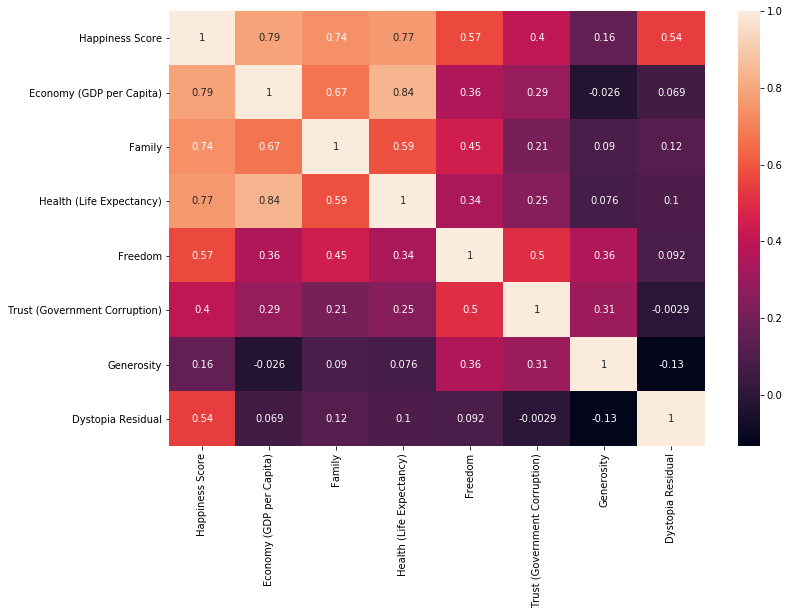

In [85]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True)
plt.show()

## Prepare the data for ML

We need to split off a test set:

In [86]:
X_train, X_test, y_train, y_test = train_test_split(happiness.drop('Happiness Score', axis=1), happiness['Happiness Score'], 
                                                    stratify=happiness['Region'], test_size=.1, random_state=1)

In [87]:
X_train.head()

,Country,Region,Happiness Rank,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
121,Kenya,Sub-Saharan Africa,122,0.52267,0.76240,0.30147,0.40576,0.06686,0.41328,1.88326
56,Poland,Central and Eastern Europe,57,1.24585,1.04685,0.69058,0.45190,0.05500,0.14443,2.20035
89,Morocco,Middle East and Northern Africa,90,0.84058,0.38595,0.59471,0.25646,0.08404,0.04053,2.94891
41,Bahrain,Middle East and Northern Africa,42,1.44024,0.94397,0.65696,0.47375,0.25772,0.17147,2.27405
8,Australia,Australia and New Zealand,9,1.44443,1.10476,0.85120,0.56837,0.32331,0.47407,2.54650


These are the countries we'll try to predict the happiness for:

In [88]:
X_test['Country'], len(X_test)

(60                 Belarus
 70                 Romania
 101                   Laos
 75                 Somalia
 126    Congo (Brazzaville)
 138            Ivory Coast
 58                 Bolivia
 111                   Iraq
 11                 Austria
 30                Colombia
 140                 Angola
 18                 Ireland
 109             Bangladesh
 52                   Japan
 62                Slovenia
 79                  Jordan
 Name: Country, dtype: object, 16)

We drop `Country` and `Happiness Rank` as before:

In [89]:
X_train = X_train.drop(['Country', 'Happiness Rank'], axis=1)
X_test = X_test.drop(['Country', 'Happiness Rank'], axis=1)

As we know from Assignment 1, we should take care of the categorical variable `Region` by encoding it. As of scikit-learn version 0.20, the `OrdinalEncoder` is part of `sklearn.preprocessing`. (Update your environment using `conda env update` in the DAT158ML repository if you haven't done so lately, and you'll get 0.20). 

In [90]:
from sklearn.preprocessing import OrdinalEncoder

In [91]:
ordinal_encoder = OrdinalEncoder()
X_train= ordinal_encoder.fit_transform(X_train)
X_test= ordinal_encoder.fit_transform(X_test)

Inconveniently, this gives us Numpy arrays instead of Pandas data frames. Let's turn them into data frames again:

In [92]:
X_train = pd.DataFrame(data=X_train, columns=X.columns)
X_test = pd.DataFrame(data=X_test, columns=X.columns)

In [93]:
X_train.head()

,Region,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,8.0,27.0,54.0,25.0,78.0,42.0,124.0,21.0
1,1.0,100.0,116.0,95.0,97.0,32.0,30.0,55.0
2,4.0,49.0,13.0,67.0,36.0,57.0,4.0,122.0
3,4.0,125.0,93.0,88.0,104.0,116.0,40.0,65.0
4,0.0,127.0,131.0,133.0,131.0,127.0,128.0,94.0


## Random forest regressor

Now we're ready for a random forest!

In [94]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [96]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [97]:
from sklearn.metrics import mean_absolute_error

In [98]:
y_pred = rf_reg.predict(X_test)

In [99]:
mean_absolute_error(y_test, y_pred)

1.8974337500000025

Our model is off by 1.9 happiness points on average for our 16 test countries. 

The interesting question now is: "Which features are most predictive for happiness in our model?"

In [100]:
rf_reg.feature_importances_

array([0.00790822, 0.36351694, 0.0770609 , 0.31360902, 0.0616555 ,
       0.01653445, 0.01149912, 0.14821585])

In [101]:
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(X.columns)): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],3)}')

Economy (GDP per Capita): 0.364
Health (Life Expectancy): 0.314
Dystopia Residual: 0.148
Family: 0.077
Freedom: 0.062
Trust (Government Corruption): 0.017
Generosity: 0.011
Region: 0.008


> Feel free to play around with the data set further. Looking at the trends from 2015 to 2017 would be interesting (perhaps even 2018 if you download that data from the UN). You could also try to combine the data with the Gapminder data described below to get a more detailed description of the world (but note that the below Gapminder data is from 2008).

# Improving our results by understanding and tuning the hyperparameters

*See the notebook on hyperparameter tuning for random forests and XGBoost in the DAT158ML-repository*

# Extra: another regression problem

We'll use a simple data set to predict life expectancy in a country based on a few features. The data comes from <a href="https://www.gapminder.org/">Gapminder</a>, prepared by DataCamp

In [102]:
url = 'https://assets.datacamp.com/production/course_1939/datasets/gm_2008_region.csv'

In [103]:
gapminder = pd.read_csv(url)

In [104]:
gapminder.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,Middle East & North Africa
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,Sub-Saharan Africa
2,40381860.0,2.24,0.5,4.785170,27.50170,14646.0,118.8915,75.5,15.4,America
3,2975029.0,1.40,0.1,1.804106,25.35542,7383.0,132.8108,72.5,20.0,Europe & Central Asia
4,21370348.0,1.96,0.1,18.016313,27.56373,41312.0,117.3755,81.5,5.2,East Asia & Pacific


In [105]:
gapminder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 10 columns):
population         139 non-null float64
fertility          139 non-null float64
HIV                139 non-null float64
CO2                139 non-null float64
BMI_male           139 non-null float64
GDP                139 non-null float64
BMI_female         139 non-null float64
life               139 non-null float64
child_mortality    139 non-null float64
Region             139 non-null object
dtypes: float64(9), object(1)
memory usage: 10.9+ KB


There are 9 numeric features, with `life` as our target feature, and one categorical (`Region`).

As we remember from Assignment 1, it's a good idea to get a feel for the data by visualizing the features using histograms, correlations and boxplots:

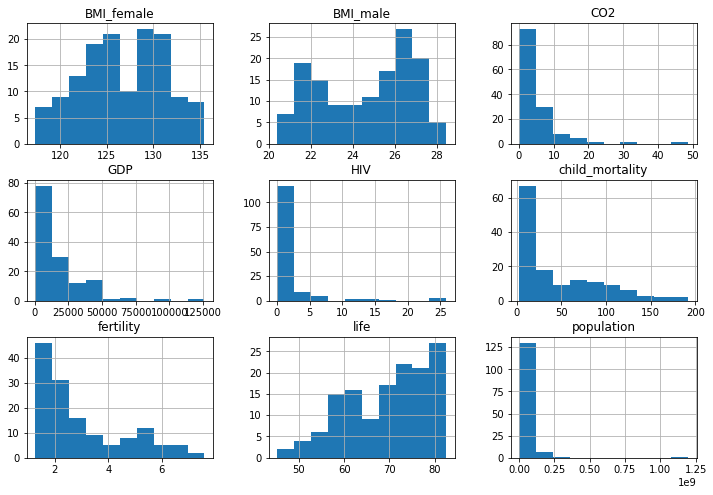

In [106]:
gapminder.hist(figsize=(12,8))
plt.show()

`Region` is a categorical feature:

In [107]:
gapminder['Region'].value_counts()

Europe & Central Asia         41
Sub-Saharan Africa            40
America                       27
East Asia & Pacific           14
Middle East & North Africa    10
South Asia                     7
Name: Region, dtype: int64

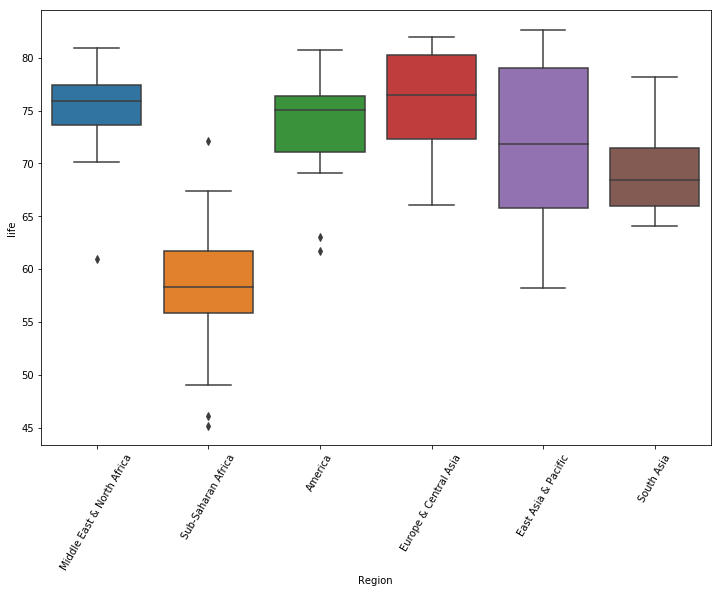

In [108]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='Region', y='life', data=gapminder)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
plt.show()

Let's put the target into `y` and the rest in `X`:

In [109]:
X = gapminder.drop('life', axis=1)
y = gapminder['life']

...and split off a test set:

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [111]:
X_train.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,child_mortality,Region
45,1586749.0,5.80,1.7,0.251002,21.65029,1566.0,130.2080,87.4,Sub-Saharan Africa
81,1238013.0,1.58,0.9,3.078763,25.15669,14615.0,130.8786,15.8,Sub-Saharan Africa
89,16519862.0,1.77,0.2,10.533028,26.01541,47388.0,121.6950,4.8,Europe & Central Asia
95,2652281.0,2.89,0.1,15.572080,26.24109,47799.0,126.8870,11.9,Middle East & North Africa
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,29.5,Middle East & North Africa


As we know from Assignment 1, we should take care of the categorical variable `Region` by encoding it. As of scikit-learn version 0.20, the `OrdinalEncoder` is part of `sklearn.preprocessing`. (Update your environment using `conda env update` in the DAT158ML repository if you haven't done so lately, and you'll get 0.20). 

In [112]:
from sklearn.preprocessing import OrdinalEncoder

In [113]:
ordinal_encoder = OrdinalEncoder()
X_train= ordinal_encoder.fit_transform(X_train)
X_test= ordinal_encoder.fit_transform(X_test)

Inconveniently, this gives us Numpy arrays instead of Pandas data frames. Let's turn them into data frames again:

In [114]:
X_train = pd.DataFrame(data=X_train, columns=X.columns)
X_test = pd.DataFrame(data=X_test, columns=X.columns)

In [115]:
X_train.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,child_mortality,Region
0,17.0,85.0,17.0,17.0,14.0,11.0,76.0,80.0,5.0
1,12.0,15.0,10.0,59.0,54.0,66.0,84.0,31.0,5.0
2,67.0,18.0,2.0,97.0,69.0,97.0,17.0,11.0,2.0
3,21.0,53.0,1.0,100.0,72.0,99.0,57.0,25.0,3.0
4,79.0,51.0,1.0,62.0,48.0,61.0,70.0,51.0,3.0


Now we're ready for a random forest!

In [116]:
from sklearn.ensemble import RandomForestRegressor

In [117]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [118]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [120]:
y_pred = rf_reg.predict(X_test)

In [121]:
mean_squared_error(y_test, y_pred)

67.48508731428564

In [122]:
mean_absolute_error(y_test, y_pred)

6.404228571428561

Our model is off by 6.4 years on average. There are many things you could do to try to improve the model. Feel free to experiment! 

Let's look at the feature importances. Which features are most predictive for life expectancy in our model?

In [123]:
rf_reg.feature_importances_

array([0.01485897, 0.00807645, 0.06356852, 0.00657134, 0.0084477 ,
       0.02841374, 0.0150021 , 0.85107967, 0.00398151])

In [124]:
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(X.columns)): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],3)}')

child_mortality: 0.851
HIV: 0.064
GDP: 0.028
BMI_female: 0.015
population: 0.015
BMI_male: 0.008
fertility: 0.008
CO2: 0.007
Region: 0.004


# Extra: another classification problem

We'll use a classification data set from Kaggle: https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones

Have a look here for a demo of how the data was collected: http://www.youtube.com/watch?v=XOEN9W05_4A. 

In [125]:
from IPython.display import HTML

In [126]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/XOEN9W05_4A" frameborder="0" allow="autoplay" allowfullscreen></iframe>')

To download data sets from Kaggle, you should use the Kaggle API. Preferably from within a notebook (for documentation and reproducibility purposes).

### Using the Kaggle API

First we need to decide where to store the data. Any time you work with paths in Python you should consider <a href="https://docs.python.org/3.6/library/pathlib.html">pathlib</a>. It's super convenient. 

In [127]:
from pathlib import Path

In [128]:
NB_DIR = %pwd # Sets NB_DIR to the current directory
NB_DIR = Path(NB_DIR)

In [129]:
DATA = NB_DIR/'data'

In [130]:
DATA.mkdir(exist_ok=True)

We'll run our Kaggle API command from within Python using the <a href="https://docs.python.org/3.6/library/subprocess.html">subprocess</a> module. 

In [131]:
import subprocess

In [132]:
command = f'kaggle datasets download -d uciml/human-activity-recognition-with-smartphones -p {DATA}'

In [133]:
subprocess.call(command, shell=True)

0

We see that we've downloaded a zip file:

In [134]:
%ls $DATA

 Volume in drive C is Local Disk
 Volume Serial Number is 82A6-EE0C

 Directory of C:\Users\alexa\Dropbox\Jobb\HIB\Kurs\DAT158\DAT158ML\Part4-tree_based_models\data

10/22/2018  11:25 AM    <DIR>          .
10/22/2018  11:25 AM    <DIR>          ..
10/22/2018  11:23 AM            16,557 2015.csv
10/22/2018  11:23 AM            17,132 2016.csv
10/22/2018  11:23 AM            29,536 2017.csv
10/22/2018  11:25 AM        26,222,239 human-activity-recognition-with-smartphones.zip
10/22/2018  11:23 AM            29,425 world-happiness.zip
               5 File(s)     26,314,889 bytes
               2 Dir(s)  740,265,693,184 bytes free


Let's unzip it:

In [135]:
import zipfile

In [136]:
for file in DATA.glob('*.zip'):
    with zipfile.ZipFile(DATA/file,"r") as zip_ref:
        zip_ref.extractall(DATA)

In [137]:
%ls $DATA

 Volume in drive C is Local Disk
 Volume Serial Number is 82A6-EE0C

 Directory of C:\Users\alexa\Dropbox\Jobb\HIB\Kurs\DAT158\DAT158ML\Part4-tree_based_models\data

10/22/2018  11:25 AM    <DIR>          .
10/22/2018  11:25 AM    <DIR>          ..
10/22/2018  11:25 AM            16,557 2015.csv
10/22/2018  11:25 AM            17,132 2016.csv
10/22/2018  11:25 AM            29,536 2017.csv
10/22/2018  11:25 AM        26,222,239 human-activity-recognition-with-smartphones.zip
10/22/2018  11:25 AM        19,324,796 test.csv
10/22/2018  11:25 AM        48,138,764 train.csv
10/22/2018  11:23 AM            29,425 world-happiness.zip
               7 File(s)     93,778,449 bytes
               2 Dir(s)  740,198,223,872 bytes free


We have a CSV of training data and a CSV of test data.

In [138]:
action_train = pd.read_csv(DATA/'train.csv')

In [139]:
action_test = pd.read_csv(DATA/'test.csv')

In [140]:
action_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [141]:
action_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


In [142]:
action_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


We see that we get a bunch of sensor measurements (561 columns of measurements) plus the label of the activity.

We need to separate the target ('Activity') from the rest:

In [143]:
X_train, y_train = action_train.drop('Activity', axis=1), action_train['Activity']
X_test, y_test = action_test.drop('Activity', axis=1), action_test['Activity']

In [144]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1


Here are some labels:

In [145]:
np.random.choice(y_train, size=50)

array(['WALKING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING',
       'WALKING_UPSTAIRS', 'SITTING', 'SITTING', 'STANDING',
       'WALKING_DOWNSTAIRS', 'SITTING', 'SITTING', 'LAYING',
       'WALKING_UPSTAIRS', 'STANDING', 'WALKING', 'SITTING',
       'WALKING_DOWNSTAIRS', 'LAYING', 'WALKING', 'STANDING', 'WALKING',
       'WALKING_UPSTAIRS', 'SITTING', 'SITTING', 'WALKING_UPSTAIRS',
       'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'WALKING_DOWNSTAIRS',
       'WALKING', 'WALKING', 'WALKING_UPSTAIRS', 'STANDING',
       'WALKING_DOWNSTAIRS', 'WALKING', 'STANDING', 'WALKING_UPSTAIRS',
       'SITTING', 'WALKING_UPSTAIRS', 'SITTING', 'STANDING',
       'WALKING_DOWNSTAIRS', 'SITTING', 'WALKING_DOWNSTAIRS',
       'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS',
       'STANDING', 'LAYING'], dtype=object)

The set of unique labels in `y_train` is:

In [146]:
np.unique(y_train)

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

We'll encode these using `LabelBinarizer`:

In [147]:
from sklearn.preprocessing import LabelBinarizer

In [148]:
lb = LabelBinarizer()

In [149]:
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [150]:
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

In [151]:
lb.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype='<U18')

In [152]:
y_train[:5]

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

Now let's try out a random forest!

# Classification

In [153]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [155]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [156]:
rf_clf.score(X_test, y_test)

0.8971835765184933

That was easy! 90% accuracy without even trying!

Notice that our model is overfitting a lot: 

In [157]:
rf_clf.score(X_train, y_train)

1.0

Feel free to try harder! Including tuning hyperparameters and fixing the overfitting issue. But first, let's look at what the trained model can tell us about our data.

## Feature importances

In [158]:
importances = rf_clf.feature_importances_

In [159]:
# Find index of those with highest importance, sorted from largest to smallest:
indices = np.argsort(importances)[::-1]

In [160]:
num = 10

In [161]:
for f in range(num): 
    print(f'{X_train.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

tGravityAcc-mean()-X: 0.03
tGravityAcc-max()-X: 0.03
tGravityAcc-max()-Y: 0.03
tGravityAcc-min()-X: 0.03
angle(Y,gravityMean): 0.03
tGravityAcc-min()-Y: 0.03
tGravityAcc-energy()-X: 0.02
tGravityAcc-mean()-Y: 0.02
angle(X,gravityMean): 0.02
tGravityAcc-energy()-Y: 0.02


We see that the `tGravityAcc-max()-Y` is way more important than any of the others. 

What are the least important features?

In [162]:
indices_smallest = np.argsort(importances)

In [163]:
num=60

In [164]:
for f in range(num): 
    print(f'{X_train.columns[indices_smallest[f]]}: {np.round(importances[indices_smallest[f]],4)}')

fBodyAccJerk-min()-Y: 0.0001
fBodyAccJerk-bandsEnergy()-57,64.2: 0.0001
fBodyBodyGyroJerkMag-maxInds: 0.0001
fBodyAccJerk-bandsEnergy()-49,64: 0.0001
fBodyBodyGyroJerkMag-entropy(): 0.0001
fBodyAccJerk-min()-Z: 0.0001
tBodyAccJerk-max()-Y: 0.0001
fBodyGyro-bandsEnergy()-49,64.1: 0.0001
fBodyAccJerk-bandsEnergy()-49,56: 0.0001
fBodyAcc-bandsEnergy()-33,48: 0.0001
fBodyAccJerk-entropy()-Y: 0.0001
fBodyAcc-entropy()-Y: 0.0001
fBodyAccJerk-min()-X: 0.0001
fBodyAcc-bandsEnergy()-57,64: 0.0001
fBodyBodyAccJerkMag-iqr(): 0.0001
fBodyBodyGyroJerkMag-mean(): 0.0001
fBodyAccJerk-bandsEnergy()-57,64: 0.0001
fBodyBodyGyroJerkMag-sma(): 0.0001
fBodyAcc-bandsEnergy()-33,40.1: 0.0001
fBodyAccJerk-bandsEnergy()-57,64.1: 0.0001
tGravityAccMag-arCoeff()4: 0.0001
tBodyGyro-arCoeff()-X,2: 0.0001
tBodyAccMag-arCoeff()4: 0.0001
tBodyAccJerk-mean()-Z: 0.0001
fBodyAcc-bandsEnergy()-49,56: 0.0001
tBodyAcc-arCoeff()-X,3: 0.0001
fBodyAcc-min()-X: 0.0001
angle(tBodyAccMean,gravity): 0.0001
fBodyAcc-iqr()-Y: 0.000

The first 50 or so features weren't important at all for our model. Dropping them shouldn't effect the accuracy. Which could be interesting for product design: from the model's perspective, there are superfluous sensor measurements in our system!

Let's try to drop the 200 least important features:

In [165]:
drop = 200

In [166]:
X_train_smaller = X_train.drop(X_train.columns[indices_smallest[:drop]], axis=1)
X_test_smaller = X_test.drop(X_test.columns[indices_smallest[:drop]], axis=1)

In [167]:
X_train_smaller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 362 entries, tBodyAcc-std()-X to subject
dtypes: float64(361), int64(1)
memory usage: 20.3 MB


In [168]:
rf_clf_smaller = RandomForestClassifier(n_estimators=100, random_state=42)

In [169]:
rf_clf_smaller.fit(X_train_smaller, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [170]:
rf_clf_smaller.score(X_test_smaller, y_test)

0.8988802171700034

Our model actually improved slightly!

Feel free to play around with dropping more or fewer features.

> **NB!** Remember that there's randomness in how the model is constructed, and there are multiple hyperparameters! If you run it all again with a different random seed or different hyperparameters, the feature importances may change.

### Confusion matrix

It's interesting to check which movement classes the model was confused about:

In [171]:
y_pred = rf_clf_smaller.predict(X_test_smaller)

In [172]:
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [173]:
cm = confusion_matrix(y_test, y_pred)

In [174]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization


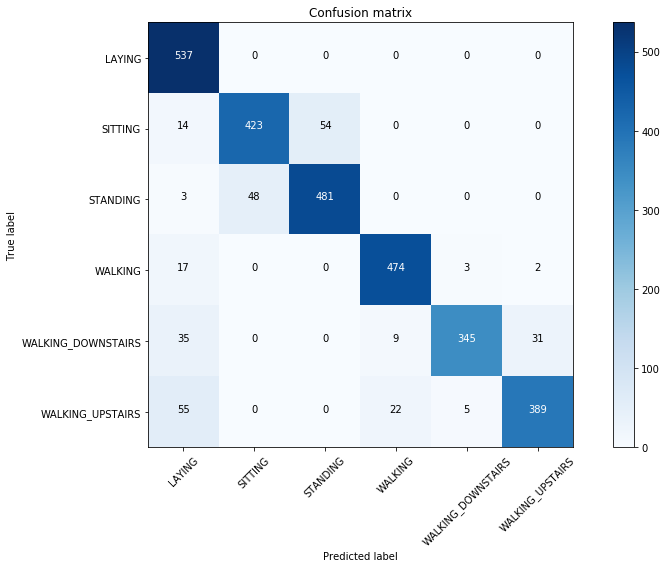

In [175]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(cm, lb.classes_)

Normalized confusion matrix


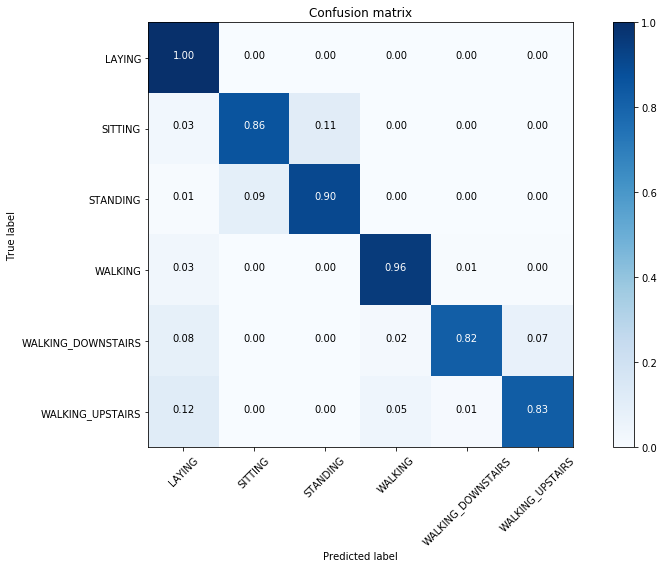

In [176]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(cm, lb.classes_, normalize=True)